#### Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import cv2
import re
from PIL import Image
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Nadam 
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Processing for Autoencoder - (Using Raw FacePoints): ####

In [2]:
# file_names = ["IMG_4749_David_R1", "IMG_4751_David_R2", "IMG_0269_David_R3", 
#              "IMG_4740_Daniel_R1", "IMG_4742_Daniel_R2", "IMG_0226_Daniel_R3",
#             "IMG_4840_Hiandra_R1", "IMG_0253_Hiandra_R2", "IMG_0254_Hiandra_R3", 
#              "IMG_4843_Shreya_R1", "IMG_0222_Shreya_R2", "IMG_0224_Shreya_R3",
#              "IMG_0235_Joey_R1", "IMG_0236_Joey_R2", "IMG_0237_Joey_R3",
#              "IMG_0238_Pablo_R1", "IMG_0240_Pablo_R2", "IMG_0241_Pablo_R3",
#              "IMG_0242_Sungho_R1", "IMG_0243_Sungho_R2", "IMG_0268_Sungho_R3",
#              "IMG_0244_Johan_R1", "IMG_0245_Johan_R2", "IMG_0247_Johan_R3",
#              "IMG_0255_Ruth_R1", "IMG_0256_Ruth_R2", "IMG_0257_Ruth_R3",
#              "IMG_0248_Ana_R1", "IMG_0249_Ana_R2", "IMG_0252_Ana_R3",
#              "IMG_0258_Paula_R1", "IMG_0259_Paula_R2.1", "IMG_0262_Paula_R2.2", "IMG_0263_Paula_R3",
#              "IMG_0265_Hymalai_R1", "IMG_0266_Hymalai_R2", "IMG_0267_Hymalai_R3"
#              ]

file_names = ["IMG_0226_Daniel_R3", "IMG_4742_Daniel_R2"]
i=0

for file_name in file_names:
  file_name_cap = file_name[4:]
  x = file_name_cap.find("_")
  file_name_cap = file_name_cap[x+1:]
  file_name_img = file_name + "_img"
  target_file = "/content/drive/MyDrive/Regressor/FaceShieldPoints_numpy_Train/" + file_name + "_LIMITED.npy" 
  feature_file = "/content/drive/MyDrive/Regressor/Capacitive_Data_Train/Processed/"+ file_name_cap +".npy" 
  targets = np.load(target_file)
  features = np.load(feature_file)
  targets = targets[0:len(features)]

  print("# of Features - " + file_name_cap + ":", len(features))
  print("# of Targets - " + file_name_cap + ":", len(targets))

  if (i==0):
    total_features = features
    total_targets = targets
  else:
    total_features = np.concatenate((total_features, features), axis=0)
    total_targets = np.concatenate((total_targets, targets), axis=0)
  
  i=i+1

#total_targets = total_targets.transpose(0, 2, 1)
print("--------------------------------------------")
print("Total # of Features: ", total_features.shape)
print("Total # of Targets: ", total_targets.shape)

# of Features - Daniel_R3: 10811
# of Targets - Daniel_R3: 10811
# of Features - Daniel_R2: 11244
# of Targets - Daniel_R2: 11244
--------------------------------------------
Total # of Features:  (22055, 10, 8)
Total # of Targets:  (22055, 2, 10)


PRINT LATENT SPACE

In [3]:
#Prepare data for 1D CNN model.
x_train = total_features
#n_output = enconded dimension.
#n_output = total_targets.shape[1]
y_train = total_targets

n_output= 8

#CNN:
# Parameters:
dropoutrate = 0.2
EPOCHS_CNN = 50

model_regressor = Sequential()

model_regressor.add(Conv1D(filters=8, kernel_size=5, padding='same', activation='relu', kernel_initializer = "he_uniform", input_shape=(x_train.shape[1], x_train.shape[2])))
model_regressor.add(MaxPooling1D())
model_regressor.add(BatchNormalization())
model_regressor.add(Dropout(0.2))

model_regressor.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu', kernel_initializer = "he_uniform"))
model_regressor.add(MaxPooling1D())
model_regressor.add(BatchNormalization())
model_regressor.add(Dropout(0.2))

#model_regressor.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu', kernel_initializer = "he_uniform"))
#model_regressor.add(MaxPooling1D())
#model_regressor.add(BatchNormalization())
#model_regressor.add(Dropout(0.2))

model_regressor.add(Conv1D(filters=10, kernel_size=7, padding='same', activation='relu', kernel_initializer = "he_uniform"))
model_regressor.add(BatchNormalization())

# 1D CONV
#(10, 8) -> (5, 16) -> (2, 32) -> (1, 64) -> flatten -> dense (30)

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_regressor.compile(loss='mse', optimizer=nadam, metrics=['mse'])
# Show summary of model.
model_regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 8)             328       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 8)             0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 5, 8)             32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5, 8)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 16)             656       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 16)            0

In [4]:
total_features_exp = total_features[:, :, :, np.newaxis]
total_features_exp.shape

(22055, 10, 8, 1)

Epoch 1/50
552/552 [==============================] - 7s 4ms/step - loss: 130.5130 - mse: 130.5130 - val_loss: 91.4363 - val_mse: 91.4363
Epoch 2/50
552/552 [==============================] - 2s 4ms/step - loss: 114.9228 - mse: 114.9228 - val_loss: 80.1771 - val_mse: 80.1771
Epoch 3/50
552/552 [==============================] - 4s 8ms/step - loss: 102.9049 - mse: 102.9049 - val_loss: 70.6544 - val_mse: 70.6544
Epoch 4/50
552/552 [==============================] - 2s 4ms/step - loss: 92.2246 - mse: 92.2246 - val_loss: 62.3231 - val_mse: 62.3231
Epoch 5/50
552/552 [==============================] - 2s 4ms/step - loss: 82.6484 - mse: 82.6484 - val_loss: 54.9901 - val_mse: 54.9901
Epoch 6/50
552/552 [==============================] - 2s 4ms/step - loss: 74.1099 - mse: 74.1099 - val_loss: 48.6840 - val_mse: 48.6840
Epoch 7/50
552/552 [==============================] - 2s 4ms/step - loss: 66.4336 - mse: 66.4336 - val_loss: 42.9635 - val_mse: 42.9635
Epoch 8/50
552/552 [======================

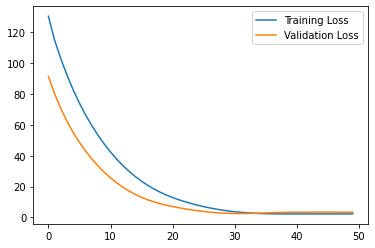

In [5]:
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_CNN = model_regressor.fit(x_train, y_train, batch_size=32, validation_split=0.2, epochs=EPOCHS_CNN)

plt.plot(history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [6]:
total_targets.shape

(22055, 2, 10)

In [7]:
model_regressor.save('/content/drive/MyDrive/Models/model_CNN_limited_diff.h5')

690/690 [==============================] - 1s 2ms/step


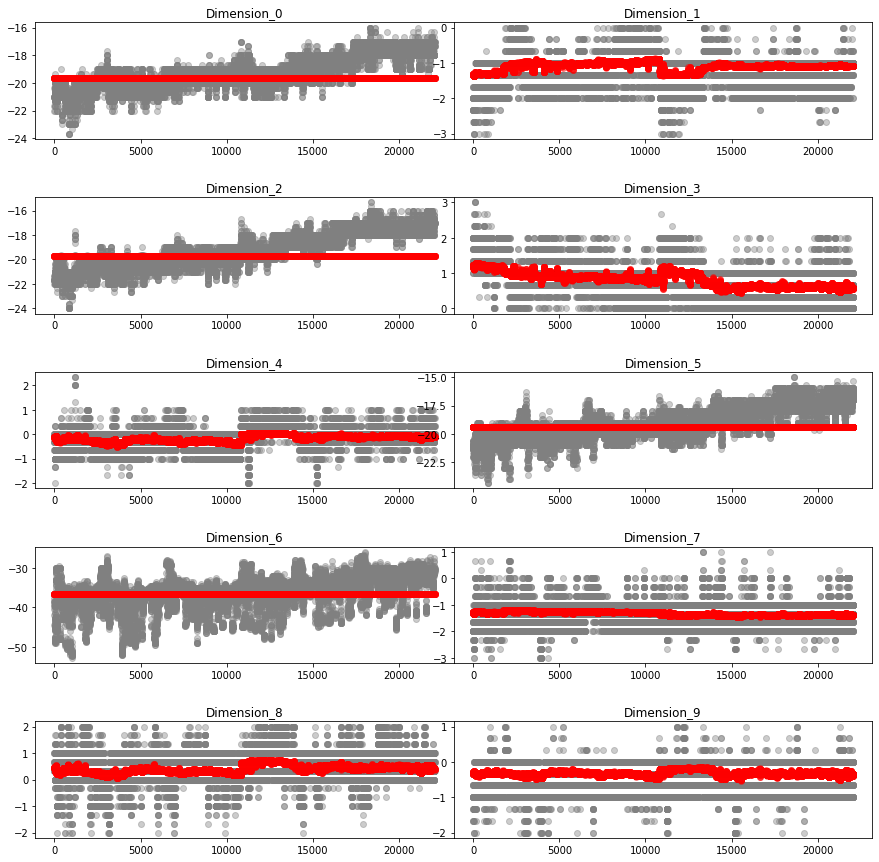

In [36]:
model_regressor = tf.keras.models.load_model('/content/drive/MyDrive/Models/model_CNN_limited_diff.h5')
regressor_pred = model_regressor.predict(total_features)

fig, axs = plt.subplots(5,2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):

    axs[i].scatter(np.arange(start=0, stop=len(total_targets[:,0,i])), total_targets[:,0,i], alpha=0.4, color='grey')
    axs[i].scatter(np.arange(start=0, stop=len(regressor_pred[:,0,i])), regressor_pred[:,0,i], alpha=0.4, color='red')
    axs[i].set_title("Dimension_" + str(i))

name = "/content/drive/MyDrive/Models/LatentSpace_img.png"
plt.savefig(name, bbox_inches='tight', pad_inches=0)

690/690 [==============================] - 1s 2ms/step


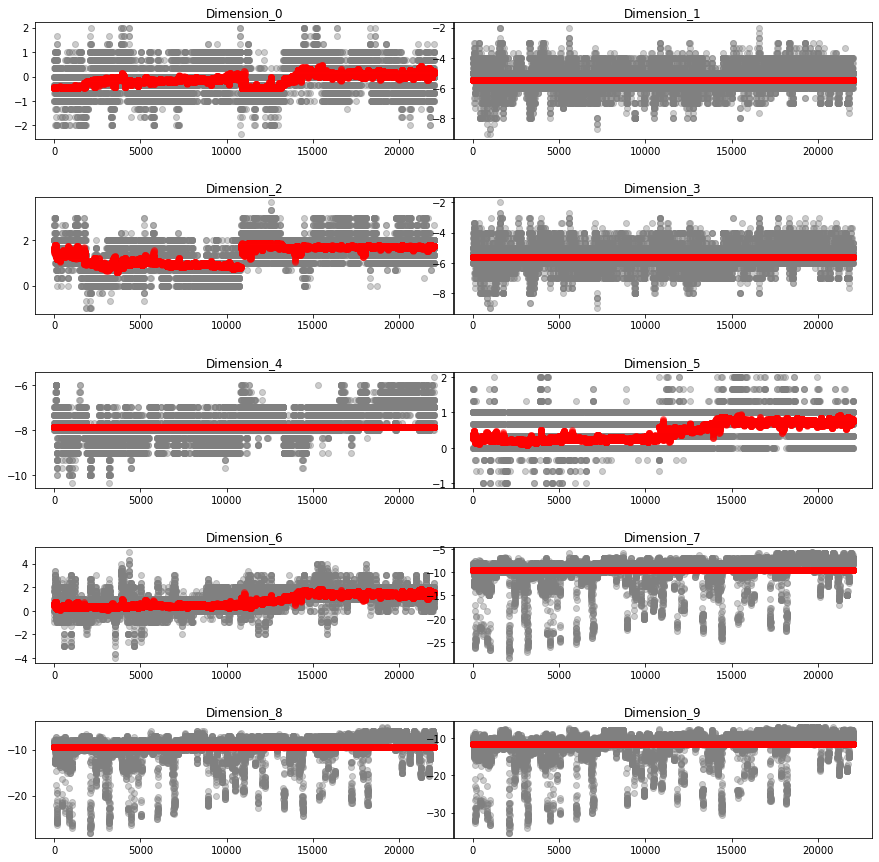

In [35]:
model_regressor = tf.keras.models.load_model('/content/drive/MyDrive/Models/model_CNN_limited_diff.h5')
regressor_pred = model_regressor.predict(total_features)

fig, axs = plt.subplots(5,2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):

    axs[i].scatter(np.arange(start=0, stop=len(total_targets[:,1,i])), total_targets[:,1,i], alpha=0.4, color='grey')
    axs[i].scatter(np.arange(start=0, stop=len(regressor_pred[:,1,i])), regressor_pred[:,1,i], alpha=0.4, color='red')
    axs[i].set_title("Dimension_" + str(i))

name = "/content/drive/MyDrive/Models/LatentSpace_img.png"
plt.savefig(name, bbox_inches='tight', pad_inches=0)

In [24]:
regressor_pred.shape

(22055, 2, 10)

In [23]:
total_targets.shape

(22055, 2, 10)

In [33]:
total_targets[0,0,:]

array([-21.        ,  -1.66666667, -21.66666667,   1.        ,
         0.        , -21.        , -38.66666667,  -1.66666667,
         0.33333333,  -0.33333333])